In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder


In [2]:
# Chemins vers les images et les données CSV
images_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/images/image_train"
X_csv_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/X_train_update.csv"
y_csv_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/Y_train_CVw08PX.csv"


# Chargement des données
X_df = pd.read_csv(X_csv_path)
y_df = pd.read_csv(y_csv_path)

# Assurez-vous que les colonnes 'imageid' et 'productid' sont correctes pour correspondre aux noms de fichiers
X_df['image_path'] = X_df.apply(lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1)

In [3]:
# Vérifiez que la colonne 'prdtypecode' existe dans y_df et ajoutez-la à X_df si nécessaire
if 'prdtypecode' not in X_df.columns and 'prdtypecode' in y_df.columns:
    X_df = X_df.join(y_df['prdtypecode']) 



In [4]:
# Convertir 'prdtypecode' en string si nécessaire
X_df['prdtypecode'] = X_df['prdtypecode'].astype(str)

In [5]:
# Convertir les labels en chaînes si nécessaire
y_df['prdtypecode'] = y_df['prdtypecode'].astype(str)


In [6]:
from sklearn.model_selection import train_test_split

# Diviser les données en un sous-ensemble pour une validation rapide
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_df['image_path'], y_df['prdtypecode'], test_size=0.1, random_state=42)

# Convertir les labels en format one-hot
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_val)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator_val = datagen_val.flow_from_dataframe(
    dataframe=pd.concat([X_train_val, y_train_val], axis=1),
    directory=images_path,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Créer le modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Found 76424 validated image filenames belonging to 27 classes.


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,952,667 (49.41 MB)

 Trainable params: 12,952,667 (49.41 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entraînement du modèle
history = model.fit(
    train_generator_val,
    steps_per_epoch=100,  # Nombre de steps réduit pour le test
    epochs=30  # Nombre réduit d'époches pour le test
)

Epoch 1/30


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.0963 - loss: 3.2888
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1767 - loss: 2.9393
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2437 - loss: 2.7451
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2455 - loss: 2.6519
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.2837 - loss: 2.5854
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2924 - loss: 2.5050
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3209 - loss: 2.4331
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.3195 - loss: 2.4403
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 882ms/step - accuracy: 0.3202 - loss: 2.3581
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3474 - loss: 2.2796
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3561 - loss: 2.2437
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/s

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 752ms/step - accuracy: 0.4421 - loss: 1.9526
Epoch 26/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 874ms/step - accuracy: 0.4669 - loss: 1.8675
Epoch 27/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 787ms/step - accuracy: 0.4456 - loss: 1.9347
Epoch 28/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 782ms/step - accuracy: 0.4396 - loss: 1.9261
Epoch 29/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 699ms/step - accuracy: 0.4584 - loss: 1.9461
Epoch 30/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 739ms/step - accuracy: 0.4415 - loss: 1.9027


In [10]:
import numpy as np

# Calcul du nombre de steps nécessaire, en convertissant le résultat en int pour éviter des erreurs de type
steps_per_epoch = int(np.ceil(len(X_train_val) / 32))
# Évaluation du modèle sur l'ensemble de train
loss, accuracy = model.evaluate(train_generator_val, steps=steps_per_epoch)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2389/2389 ━━━━━━━━━━━━━━━━━━━━ 1025s 429ms/step - accuracy: 0.5021 - loss: 1.7303
Test Loss: 1.7324296236038208
Test Accuracy: 0.5022767782211304


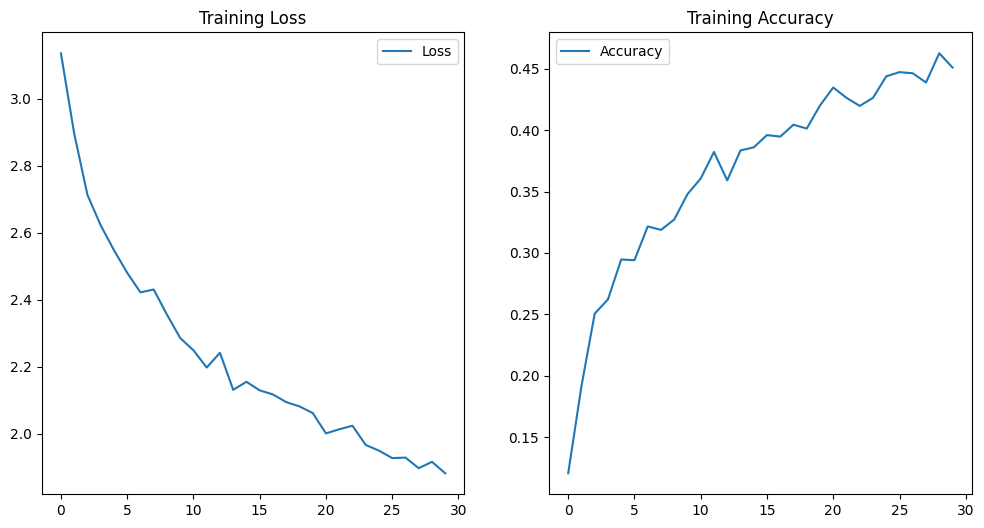

In [11]:
# Affichage des courbes de performance
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [12]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=pd.concat([X_test_val, y_test_val], axis=1),
    directory=images_path,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=(128, 128),
    batch_size=32,  
    class_mode='categorical',
    shuffle=False  # Important : Ne pas mélanger les données pour évaluation
)


Found 8492 validated image filenames belonging to 27 classes.


In [13]:
import numpy as np

# Calcul du nombre de steps nécessaire, en convertissant le résultat en int pour éviter des erreurs de type
steps_per_epoch = int(np.ceil(len(X_test_val) / 32))

# Évaluation du modèle sur l'ensemble de test
loss, accuracy = model.evaluate(test_generator, steps=steps_per_epoch)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


266/266 ━━━━━━━━━━━━━━━━━━━━ 207s 781ms/step - accuracy: 0.4404 - loss: 1.9476
Test Loss: 1.9267737865447998
Test Accuracy: 0.4448893070220947


In [14]:
from sklearn.metrics import f1_score
import numpy as np


In [15]:
test_generator.reset()  # Réinitialisation nécessaire avant la prédiction
predictions = model.predict(test_generator, steps=steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 76s 283ms/step


In [16]:
# Récupérer les vraies étiquettes
true_classes = test_generator.classes

# Calcul du score F1
f1 = f1_score(true_classes, predicted_classes, average='macro')  # 'macro' pour le score F1 non pondéré par classe
print(f"F1 Score: {f1}")


F1 Score: 0.3422430317366818
